## Step 1: Find a Story

Breast cancer is the most common type of malignant cancer in women; fortunately, effective treatments are available if it is caught early. When a suspicious lump is detected, a biopsy (removal of tissue) is the gold standard for diagnosis. The biopsied cells are viewed microscopically, with the goal of measuring specific characteristics that can indicate presence or absence of malignant disease.

The rapid growth in image analysis capabilities has allowed for distinction of cellular dimensions, shape, and textural features. The ability to capture these measurements is useless, however, unless we can leverage that knowledge into making more accurate diagnoses. Machine learning can be used to develop diagnosis algorithms from training sets of historical specimen-diagnosis sets.

Here, we have a dataset that includes attributes computed from a digitized image of a fine needle aspirate (FNA) of a breast mass, and a target diagnosis of benign or malignant. The attributes describe characteristics of the cell nuclei--including radius, perimeter, texture, and concavity. The attributes are reported as a mean of all nuclei in the image, standard error of the mean, and the “worst” value in the image (mean of the three largest values). 

Question: can a machine learning approach be used to develop a reliable diagnosis tool? Which attributes and machine learning method lead to the best model?


## Step 2: Remember your Audience

The audience will be clinicians and health-care providers. They will want a basic understanding of how the model was derived, and, more importantly, will want to be confident that an accurate diagnosis can be made.

## Step 3: Find Data

I will use the "Breast Cancer Wisconsin (Diagnostic) Data Set", available from Kaggle.com

In [1]:
# Load packages
library(dplyr)
library(ggplot2)
library(tree)
library(e1071)

#Load Breast Cancer dataset
df <- read.csv("../../../datasets/breastcancer.csv", header = TRUE)

#Preview the dataset
head(df)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



id       diagnosis radius_mean texture_mean perimeter_mean area_mean
1   842302 M         17.99       10.38        122.80         1001.0   
2   842517 M         20.57       17.77        132.90         1326.0   
3 84300903 M         19.69       21.25        130.00         1203.0   
4 84348301 M         11.42       20.38         77.58          386.1   
5 84358402 M         20.29       14.34        135.10         1297.0   
6   843786 M         12.45       15.70         82.57          477.1   
  smoothness_mean compactness_mean concavity_mean concave.points_mean ⋯
1 0.11840         0.27760          0.3001         0.14710             ⋯
2 0.08474         0.07864          0.0869         0.07017             ⋯
3 0.10960         0.15990          0.1974         0.12790             ⋯
4 0.14250         0.28390          0.2414         0.10520             ⋯
5 0.10030         0.13280          0.1980         0.10430             ⋯
6 0.12780         0.17000          0.1578         0.08089             ⋯
  radius_worst texture_worst perimeter_worst area_worst smoothness_worst
1 25.38        17.33         184.60          2019.0     0.1622          
2 24.99        23.41         158.80          1956.0     0.1238          
3 23.57        25.53         152.50          1709.0     0.1444          
4 14.91        26.50          98.87           567.7     0.2098          
5 22.54        16.67         152.20          1575.0     0.1374          
6 15.47        23.75         103.40           741.6     0.1791          
  compactness_worst concavity_worst concave.points_worst symmetry_worst
1 0.6656            0.7119          0.2654               0.4601        
2 0.1866            0.2416          0.1860               0.2750        
3 0.4245            0.4504          0.2430               0.3613        
4 0.8663            0.6869          0.2575               0.6638        
5 0.2050            0.4000          0.1625               0.2364        
6 0.5249            0.5355          0.1741               0.3985        
  fractal_dimension_worst
1 0.11890                
2 0.08902                
3 0.08758                
4 0.17300                
5 0.07678                
6 0.12440

## Step 4: Vet Data Sources

A literature search using the name of the dataset shows that many publications have cited and used it for a similar purpose--ie, building diagnostic algorithms. If that were not the case, before working on a model, I would investigate the methods the originiators used to analyze their images, and verify with other image analysis pros that the methods are robust. I would also check with a breast cancer histopathologist to make sure the reported dimensions for the nucleus were reasonable.

In [2]:
#Clean up the dataset: 
#remove 'id' column, and all columns apart from the 'diagnosis' (target) and '_mean' attributes (predictors) columns
#later, I will repeat analysis using '_worst' attributes as predictors, to compare models

brca <- df[,c(2:12)]
head(brca)

diagnosis radius_mean texture_mean perimeter_mean area_mean smoothness_mean
1 M         17.99       10.38        122.80         1001.0    0.11840        
2 M         20.57       17.77        132.90         1326.0    0.08474        
3 M         19.69       21.25        130.00         1203.0    0.10960        
4 M         11.42       20.38         77.58          386.1    0.14250        
5 M         20.29       14.34        135.10         1297.0    0.10030        
6 M         12.45       15.70         82.57          477.1    0.12780        
  compactness_mean concavity_mean concave.points_mean symmetry_mean
1 0.27760          0.3001         0.14710             0.2419       
2 0.07864          0.0869         0.07017             0.1812       
3 0.15990          0.1974         0.12790             0.2069       
4 0.28390          0.2414         0.10520             0.2597       
5 0.13280          0.1980         0.10430             0.1809       
6 0.17000          0.1578         0.08089             0.2087       
  fractal_dimension_mean
1 0.07871               
2 0.05667               
3 0.05999               
4 0.09744               
5 0.05883               
6 0.07613

In [3]:
#Check structure and size of dataset
str(brca)
nrow(brca)

'data.frame':	569 obs. of  11 variables:
 $ diagnosis             : Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean           : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean          : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean        : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean             : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean       : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean      : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean        : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean   : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean         : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean: num  0.0787 0.0567 0.06 0.0974 0.0588 ...


[1] 569

DECISION TREE MODEL, USING ATTRIBUTE_MEAN DATA

In [4]:
#Create training and test sets. Training set will have 60% of the data (0.60*569 = 341 rows)

set.seed(123)
train_ind <- sample(seq_len(nrow(brca)), size = 341)

train <- brca[train_ind,]
test <- brca[-train_ind,]

nrow(train)
nrow(test)

[1] 341

[1] 228

In [5]:
#Define formula to predict diagnosis from all other attributes
frmla <- diagnosis ~ .

#Implement decision tree with formula and training dataset
tr1 <- tree(frmla, data = train)
summary(tr1)



Classification tree:
tree(formula = frmla, data = train)
Variables actually used in tree construction:
[1] "concave.points_mean" "radius_mean"         "texture_mean"       
[4] "perimeter_mean"     
Number of terminal nodes:  9 
Residual mean deviance:  0.2158 = 71.65 / 332 
Misclassification error rate: 0.05279 = 18 / 341 

In [6]:
#Find misclassification error rate on testing set

pred <- predict(tr1, newdata = test, type = "class")
table(pred, test$diagnosis)

rateA = 1 - ((138+71)/nrow(test))
paste("Misclassification rate is : ", rateA)

    
pred   B   M
   B 138  12
   M   7  71

[1] "Misclassification rate is :  0.0833333333333334"

NAIVE BAYES MODEL, USING ATTRIBUTE_MEAN DATA

In [7]:
#Create a NaiveBayes classifier using the same formula (all attributes as predictors) and training set

m <- naiveBayes(frmla, data = train)


In [8]:
#Assess the performance of the model by using predict function with test dataset

table(predict(m, test[,-1]), test[,1])


   
      B   M
  B 137   9
  M   8  74

In [9]:
#Find misclassification rate of NB model

rateB = 1 - ((137 + 74)/nrow(test))

paste("Misclassification rate is : ", rateB)

[1] "Misclassification rate is :  0.0745614035087719"

NAIVE BAYES PRUNED FORMULA MODEL, USING ATTRIBUTE_MEAN DATA

In [10]:
#NB model using only the features used in decision tree construction

prune_frmla <- diagnosis ~ concave.points_mean + radius_mean + texture_mean + perimeter_mean

m2 <- naiveBayes(prune_frmla, data = train)

head(test)
table(predict(m2, test[,-c(1, 5, 6, 7, 8, 10, 11)]), test[,1]) 

diagnosis radius_mean texture_mean perimeter_mean area_mean smoothness_mean
4  M         11.42       20.38         77.58         386.1     0.14250        
6  M         12.45       15.70         82.57         477.1     0.12780        
8  M         13.71       20.83         90.20         577.9     0.11890        
10 M         12.46       24.04         83.97         475.9     0.11860        
11 M         16.02       23.24        102.70         797.8     0.08206        
12 M         15.78       17.89        103.60         781.0     0.09710        
   compactness_mean concavity_mean concave.points_mean symmetry_mean
4  0.28390          0.24140        0.10520             0.2597       
6  0.17000          0.15780        0.08089             0.2087       
8  0.16450          0.09366        0.05985             0.2196       
10 0.23960          0.22730        0.08543             0.2030       
11 0.06669          0.03299        0.03323             0.1528       
12 0.12920          0.09954        0.06606             0.1842       
   fractal_dimension_mean
4  0.09744               
6  0.07613               
8  0.07451               
10 0.08243               
11 0.05697               
12 0.06082

   
      B   M
  B 138   8
  M   7  75

In [11]:
#Find misclassification rate of NB pruned formula model

rateC = 1 - ((138 + 75)/nrow(test))

paste("Misclassification rate is : ", rateC)

[1] "Misclassification rate is :  0.0657894736842105"

DECISION TREE, USING ATTRIBUTE_WORST DATA

In [12]:
#Create a new dataframe with 'diagnosis' (target) and 'worst' attributes (predictors)

brca_W <- df[,c(2,23:32)]
head(brca_W)

diagnosis radius_worst texture_worst perimeter_worst area_worst
1 M         25.38        17.33         184.60          2019.0    
2 M         24.99        23.41         158.80          1956.0    
3 M         23.57        25.53         152.50          1709.0    
4 M         14.91        26.50          98.87           567.7    
5 M         22.54        16.67         152.20          1575.0    
6 M         15.47        23.75         103.40           741.6    
  smoothness_worst compactness_worst concavity_worst concave.points_worst
1 0.1622           0.6656            0.7119          0.2654              
2 0.1238           0.1866            0.2416          0.1860              
3 0.1444           0.4245            0.4504          0.2430              
4 0.2098           0.8663            0.6869          0.2575              
5 0.1374           0.2050            0.4000          0.1625              
6 0.1791           0.5249            0.5355          0.1741              
  symmetry_worst fractal_dimension_worst
1 0.4601         0.11890                
2 0.2750         0.08902                
3 0.3613         0.08758                
4 0.6638         0.17300                
5 0.2364         0.07678                
6 0.3985         0.12440

In [13]:
#Create training and test sets

train_W <- brca_W[train_ind,]
test_W <- brca_W[-train_ind,]

#Create formula and decision tree model, to predict diagnosis from all 'worst' attributes
frmla <- diagnosis ~ .
tr2 <- tree(frmla, data = train_W)
summary(tr2)



Classification tree:
tree(formula = frmla, data = train_W)
Variables actually used in tree construction:
[1] "perimeter_worst"      "concave.points_worst" "texture_worst"       
[4] "symmetry_worst"       "concavity_worst"     
Number of terminal nodes:  10 
Residual mean deviance:  0.1138 = 37.68 / 331 
Misclassification error rate: 0.02346 = 8 / 341 

In [14]:
#Find misclassification error rate on testing set

pred <- predict(tr2, newdata = test_W, type = "class")
table(pred, test_W$diagnosis)

rateD = 1 - ((138+78)/nrow(test_W))
paste("Misclassification rate is : ", rateD)

    
pred   B   M
   B 138   5
   M   7  78

[1] "Misclassification rate is :  0.0526315789473685"

NAIVE BAYES, USING ATTRIBUTE_WORST DATA

In [15]:
#Create NB, find misclassification rate on test set 

m <- naiveBayes(frmla, data = train_W)
table(predict(m, test_W[,-1]), test_W[,1])

rateE = 1 - ((141 + 78)/nrow(test_W))
paste("Misclassification rate is : ", rateE)

   
      B   M
  B 141   5
  M   4  78

[1] "Misclassification rate is :  0.0394736842105263"

NAIVE BAYES USING PRUNED FORMULA, WITH ATTRIBUTE_WORST DATA

In [16]:
#NB model using only features used in decision tree construction

prune_frmla <- diagnosis ~ concave.points_worst + texture_worst + perimeter_worst + symmetry_worst + concavity_worst

m2 <- naiveBayes(prune_frmla, data = train_W)

head(test_W)
table(predict(m2, test_W[,-c(1, 2, 5, 6, 7, 11)]), test_W[,1]) 

rateF = 1 - ((140 + 74)/nrow(test_W))
paste("Misclassification rate is : ", rateF)

diagnosis radius_worst texture_worst perimeter_worst area_worst
4  M         14.91        26.50          98.87           567.7    
6  M         15.47        23.75         103.40           741.6    
8  M         17.06        28.14         110.60           897.0    
10 M         15.09        40.68          97.65           711.4    
11 M         19.19        33.88         123.80          1150.0    
12 M         20.42        27.28         136.50          1299.0    
   smoothness_worst compactness_worst concavity_worst concave.points_worst
4  0.2098           0.8663            0.6869          0.25750             
6  0.1791           0.5249            0.5355          0.17410             
8  0.1654           0.3682            0.2678          0.15560             
10 0.1853           1.0580            1.1050          0.22100             
11 0.1181           0.1551            0.1459          0.09975             
12 0.1396           0.5609            0.3965          0.18100             
   symmetry_worst fractal_dimension_worst
4  0.6638         0.17300                
6  0.3985         0.12440                
8  0.3196         0.11510                
10 0.4366         0.20750                
11 0.2948         0.08452                
12 0.3792         0.10480

   
      B   M
  B 140   9
  M   5  74

[1] "Misclassification rate is :  0.0614035087719298"

## Step 5: Filter Results

In [17]:
#Compile misclassification rates

"MODELS THAT USED attribute_mean DATA:"
paste("1.  Misclassification rate with Decision Tree: ", rateA)
paste("2.  Misclassification rate with NaiveBayes: ", rateB)
paste("3.  Misclassification rate with pruned NaiveBayes: ", rateC)

paste("")

"MODELS THAT USED attribute_worst DATA:"
paste("1.  Misclassification rate with Decision Tree: ", rateD)
paste("2.  Misclassification rate with NaiveBayes: ", rateE)
paste("3.  Misclassification rate with pruned NaiveBayes: ", rateF)

[1] "MODELS THAT USED attribute_mean DATA:"

[1] "1.  Misclassification rate with Decision Tree:  0.0833333333333334"

[1] "2.  Misclassification rate with NaiveBayes:  0.0745614035087719"

[1] "3.  Misclassification rate with pruned NaiveBayes:  0.0657894736842105"

[1] ""

[1] "MODELS THAT USED attribute_worst DATA:"

[1] "1.  Misclassification rate with Decision Tree:  0.0526315789473685"

[1] "2.  Misclassification rate with NaiveBayes:  0.0394736842105263"

[1] "3.  Misclassification rate with pruned NaiveBayes:  0.0614035087719298"

In [18]:
#What is the baseline misclassifiation rate, if all cases are diagnosed as benign?

table(brca$diagnosis)
paste("Baseline misclassification rate: ", 1-(357/(357+212)))


  B   M 
357 212 

[1] "Baseline misclassification rate:  0.372583479789104"

## Step 6: Visuals 

In [19]:
#Create a column chart that simply and effectively compares misclassification rates according to model and data subsets

library(plotly)

Models <- c("Decision Tree", "NaiveBayes", "Pruned NaiveBayes")
data_mean <- c(rateA, rateB, rateC)
data_worst <- c(rateD, rateE, rateF)
data <- data.frame(Models, data_mean, data_worst)

p <- plot_ly(data, x = ~Models, y = ~data_mean, type = 'bar', name = 'Attribute_mean data') %>%
  add_trace(y = ~data_worst, name = 'Attribute_worst data') %>%
  layout(title='Misclassification rate for each model', yaxis = list(title = 'Misclassification rate'), barmode = 'group')

p



Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout



HTML widgets cannot be represented in plain text (need html)

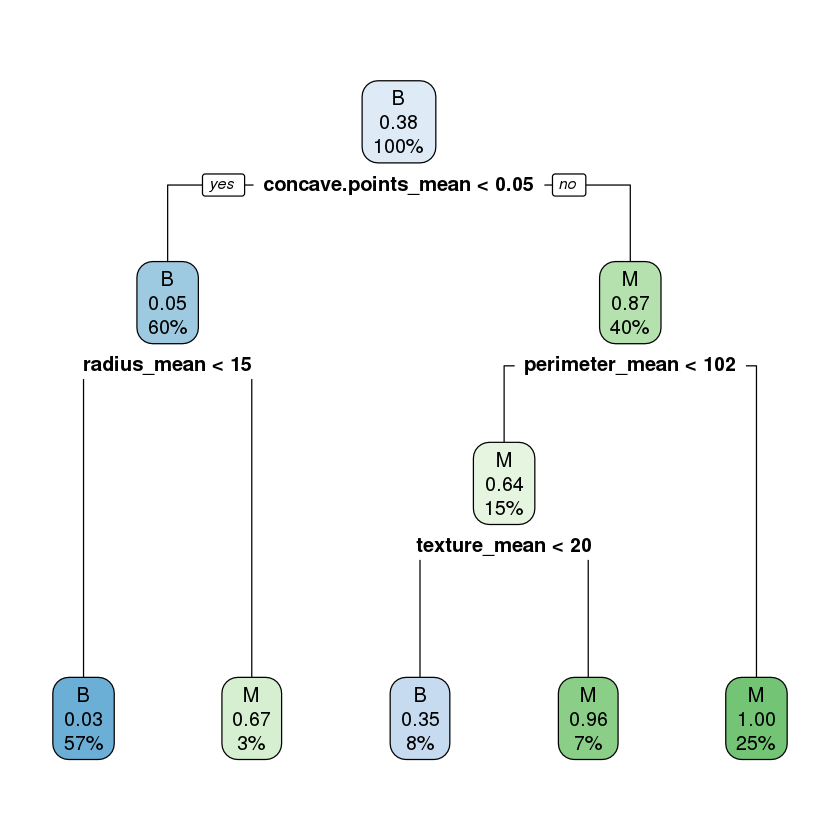

In [29]:
#Creat a nice plot of the Decision Tree model, to show how classifications are made within the model
library(rpart.plot)

binary.model <- rpart(diagnosis ~., data=train, cp=.02)
rpart.plot(binary.model)


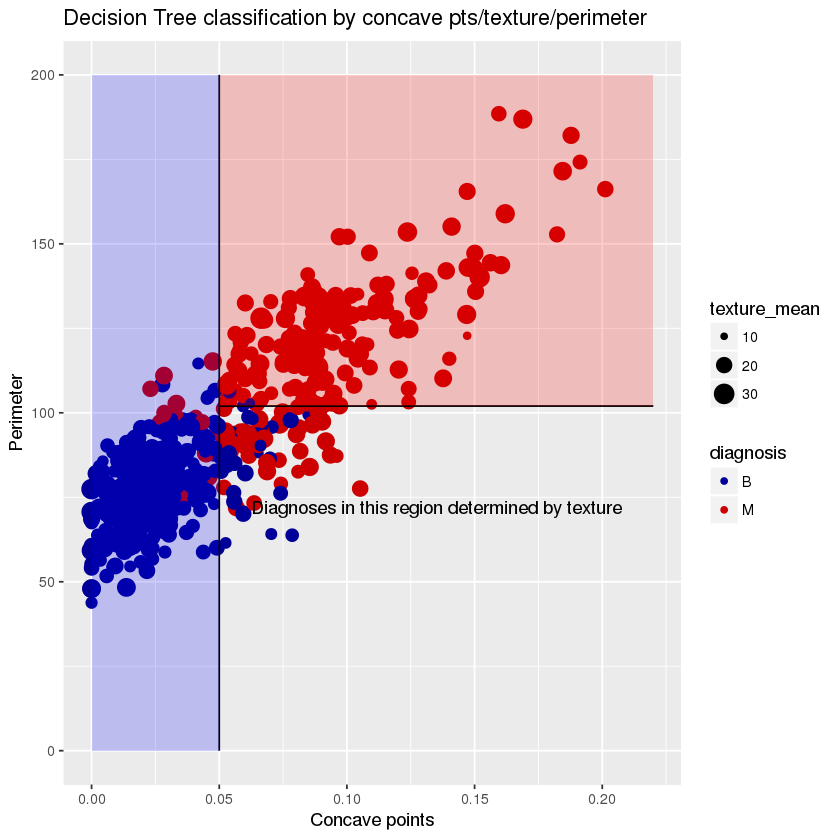

In [42]:
#Create a visual representation of how a machine learning model classifies the target

color.scheme <- c("#000099", "#CC0000")

graph <- ggplot(data=brca, aes(concave.points_mean, perimeter_mean, size=texture_mean, colour=diagnosis)) +
         geom_point() + labs(title="Decision Tree classification by concave pts/texture/perimeter",x="Concave points", y="Perimeter") +
         scale_color_manual(values=color.scheme)

graph <- graph + annotate("segment", x = 0.05, xend = 0.05, y = 0, yend = 200) +
         annotate("rect", xmin = 0.0, xmax = 0.05, ymin = 0, ymax = 200, alpha = .2, fill = 'blue') +
         annotate("segment", x = 0.05, xend = 0.22, y = 102, yend = 102) +
         annotate("rect", xmin = 0.05, xmax = 0.22, ymin = 102, ymax = 200, alpha = .2, fill = 'red') +
         annotate("text", x = 0.135, y = 72, label = "Diagnoses in this region determined by texture")

graph





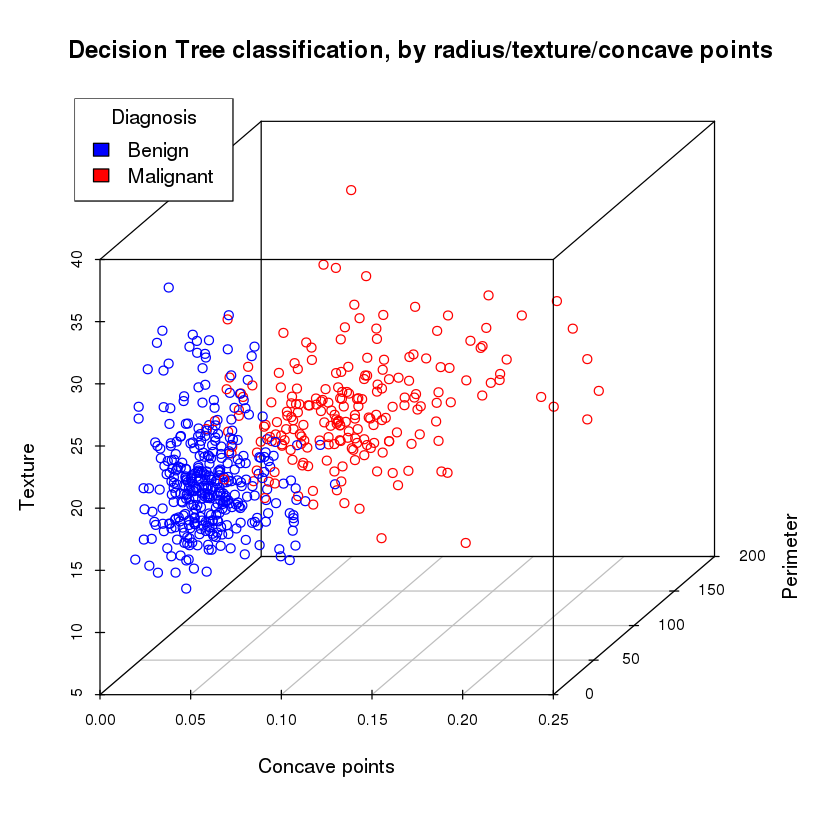

In [58]:
#Additional, 3D representation of how the model classified the target
library(scatterplot3d)

brca$dcolor[brca$diagnosis=="B"] <- "blue"
brca$dcolor[brca$diagnosis=="M"] <- "red"

plot<- with(brca, {
    scatterplot3d(concave.points_mean, perimeter_mean, texture_mean,
                 angle = 50,
                 color=dcolor,
                 main="Decision Tree classification, by radius/texture/concave points",
                 xlab="Concave points",
                 ylab="Perimeter",
                 zlab="Texture")
    legend("topleft", title="Diagnosis",
     c("Benign", "Malignant"), fill=c("blue", "red"))
})



## Conclusion: Tell the Story
In a few paragraphs, describe the story the data tells. Feel free to post examples for people to look at and give feedack about. Your classmates will be vital providers of feedback in this process. Utilize them. 

This analysis shows that machine learning can be used to build a very good tool for diagnosing metastatic disease, given that very accurate intracellular measurements can be obtained from biopsied cells.  Using either a decision tree or Naïve Bayes approach lead to an accurate model—with misclassification rates of approximately 4-8%. 

Interestingly, all three models built with the largest (so-called ‘worst’) measurements in each image had lower misclassification rates than the models built with the mean value of the attribute. This suggests a possible importance for outliers in understanding cancer cell morphology. Perhaps the distinction between a benign and malignant cell is not a continuous change in cell dimension or shape, but a ‘leap’ toward a more contorted form. It’s interesting that machine learning could end up informing biology in this regard.

An additional analysis using logistic regression would be interesting to tease out which of the morphology factors may be the best predictor. The number of concave points, texture, and perimeter were used in both decision tree models, so one of these alone may be a strong indicator. If so, image analysis experts could focus on this particular attribute in the future. It seems that concavity is an important feature, so could also be worthwhile to investigate more detailed ways to measure concavity (ie, 3D rather than 2D).

Takehome point: nuclear geometry and texture is a reliable indicator of malignant breast cancer. Machine learning can harness these quantitative attributes to create a diagnostic tool with very low misclassification rate (3% in this analysis, could be even lower with further investigation and refinement).





Conmment on visualizations:
In this data story, the scatter graph visualizations are probably more important than they may seem. In my experience, clinicians and clinical science researchers can be skeptical of machine learning, because it either is, or seems, like a black box tool. I think the rpart plot and shaded ggplot visualizations would really help drive home the point that there is nothing hidden or illogical about the classification, in this approach.
